In [1]:
import os
import time
import xml.etree.ElementTree as ET
from collections import OrderedDict

import numpy as np
import pandas as pd

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, dollar_format

In [2]:
df1 = pd.read_csv(os.path.join('data', 'index'))
display(df1)

,Year,Form,State,Path
0,2014,990PF,NJ,download990xml_2015_1/201513209349103101_publi...
1,2014,990,OH,download990xml_2015_1/201503209349307025_publi...
2,2014,990,NY,download990xml_2015_1/201513179349306981_publi...
3,2014,990PF,MI,download990xml_2015_1/201503009349100100_publi...
4,2014,990,VA,download990xml_2015_1/201503149349301075_publi...
...,...,...,...,...
2698283,2020,990,NC,download990xml_2022/202230359349301528_public.xml
2698284,2020,990,NY,download990xml_2022/202240749349300524_public.xml
2698285,2019,990,AZ,download990xml_2022/202200349349300930_public.xml
2698286,2020,990,PA,download990xml_2022/202230409349300203_public.xml


In [3]:
# Pick the years, form, and state.  Years before 2013 use a different xml tags.  

logic1 = df1['Year'] >= 2013
logic2 = df1['Form'] == '990'
logic3 = df1['State'] == 'HI'

df2 = df1[logic1 & logic2 & logic3]
df2 = df2.reset_index(drop=True)
display(df2)

,Year,Form,State,Path
0,2014,990,HI,download990xml_2015_1/201513089349301561_publi...
1,2014,990,HI,download990xml_2015_1/201503089349301685_publi...
2,2014,990,HI,download990xml_2015_1/201523099349300892_publi...
3,2014,990,HI,download990xml_2015_1/201523009349301362_publi...
4,2014,990,HI,download990xml_2015_1/201503029349300545_publi...
...,...,...,...,...
7313,2020,990,HI,download990xml_2022/202200609349301230_public.xml
7314,2020,990,HI,download990xml_2022/202240619349301489_public.xml
7315,2020,990,HI,download990xml_2022/202230389349301063_public.xml
7316,2020,990,HI,download990xml_2022/202240539349301219_public.xml


In [4]:
# Get revenue data.

list3 =[]
for path in df2['Path'].to_list():
    with open(os.path.join('data', path), 'r') as f: text = f.read()
    text = text.replace('xmlns="http://www.irs.gov/efile"', '')

    root = ET.fromstring(text)
    dic = OrderedDict()
    
    ein =   root.find('ReturnHeader/Filer/EIN')
    name1 = root.find('ReturnHeader/Filer/BusinessName/BusinessNameLine1Txt')
    name2 = root.find('ReturnHeader/Filer/BusinessName/BusinessNameLine2Txt')
    year =  root.find('ReturnHeader/TaxYr')
    
    if ein is not None: ein = ein.text
    if name1 is not None: name = name1.text
    if name2 is not None: name = name + '\n' + name2.text
    if year is not None: year = year.text
        
    grants =  root.find('ReturnData/IRS990/CYContributionsGrantsAmt')
    program = root.find('ReturnData/IRS990/CYProgramServiceRevenueAmt')
    invest =  root.find('ReturnData/IRS990/CYInvestmentIncomeAmt')
    other =   root.find('ReturnData/IRS990/CYOtherRevenueAmt')
    total =   root.find('ReturnData/IRS990/CYTotalRevenueAmt')

    if grants is not None: grants = grants.text
    if program is not None: program = program.text
    if invest is not None: invest = invest.text
    if other is not None: other = other.text
    if total is not None: total = total.text

    dic['Year'] = year
    dic['EIN'] = ein
    dic['Name'] = name
    
    dic['Grants'] = grants
    dic['PSR'] = program
    dic['Investments'] = invest
    dic['Other'] = other
    dic['Total'] = total
    
    list3.append(dic)

In [5]:
# Clean data frame.

df3 = pd.DataFrame(list3)
df3['Name'] = df3['Name'].str.upper()

cols1 = ['Year', 'EIN']
cols2 = ['Grants', 'PSR', 'Investments', 'Other']
cols3 = ['Total']

df3[cols1] = df3[cols1].astype('int64')
df3[cols2] = df3[cols2].astype('int64')
df3[cols3] = df3[cols3].astype('int64')

df3 = df3.drop_duplicates()

display(df3)

,Year,EIN,Name,Grants,PSR,Investments,Other,Total
0,2014,452488652,FRIENDS OF CHALLENGER CENTER HAWAII INC,45916,0,0,0,45916
1,2014,990215149,HOSPICE MAUI INC,833974,3775372,712,8701,4618759
2,2014,990347359,KANU I KA PONO INC,454528,12624,46,28439,495637
3,2014,996008823,AFL HOTEL & RESTAURANT WORKERS\nHEALTH & WELFA...,0,97474788,630003,-133297,97971494
4,2014,200245026,SURFING THE NATIONS,3087018,548344,74,102423,3737859
...,...,...,...,...,...,...,...,...
7313,2020,990325194,ST FRANCIS COMMUNITY HEALTH SERVICES,1890439,21569976,11006,225,23471646
7314,2020,990221127,MAUI YOUTH AND FAMILY SERVICES\nINC,1436686,2056525,113708,32466,3639385
7315,2020,990273644,KONA ADULT DAY CENTER,62217,109806,129,5150,177302
7316,2020,463368161,KAMA'AINA HALE APARTMENTS,0,1561338,0,0,1561338


In [6]:
# See what we have and check for consistency.

display(df3.info())
display(max(df3[cols2].sum(axis=1) - df3[cols3].sum(axis=1)))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7283 entries, 0 to 7317
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Year         7283 non-null   int64 
 1   EIN          7283 non-null   int64 
 2   Name         7283 non-null   object
 3   Grants       7283 non-null   int64 
 4   PSR          7283 non-null   int64 
 5   Investments  7283 non-null   int64 
 6   Other        7283 non-null   int64 
 7   Total        7283 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 512.1+ KB


None

0

In [7]:
# If an EIN has more than one name, rename all to the most recent.

df4 = df3[['EIN', 'Name']]
df4 = df4.groupby('EIN').last().reset_index()

df5 = df3.drop(['Name'], axis=1)
df5 = pd.merge(df4, df5)[df3.columns]

display(df5)

,Year,EIN,Name,Grants,PSR,Investments,Other,Total
0,2014,10602637,INTERNATIONAL PACKAGED CONCRETE\nMANUFACTURERS...,0,40054,0,0,40054
1,2014,10682872,PDMI-CARE INC,0,228773,0,0,228773
2,2016,10682872,PDMI-CARE INC,77675,0,0,0,77675
3,2019,10717030,PORTAGE BAY INSURANCE,0,24410000,1638700,0,26048700
4,2014,10757287,UFCW-HAWAII FOOD EMPLOYERS HEALTH AND WELFARE\...,0,10824425,77696,0,10902121
...,...,...,...,...,...,...,...,...
7278,2015,996086871,THE WATERHOUSE CHARITABLE TRUST,0,0,987163,700310,1687473
7279,2016,996086871,THE WATERHOUSE CHARITABLE TRUST,0,0,1449522,771135,2220657
7280,2017,996086871,THE WATERHOUSE CHARITABLE TRUST,0,0,509726,786082,1295808
7281,2018,996086871,THE WATERHOUSE CHARITABLE TRUST,0,0,1788888,792770,2581658


In [8]:
# Get the top businesses by revenue.

logic = df5['Year'] == 2019
top = df5[logic].nlargest(25, 'Total')['Name'].to_list()
display(top)

["HAWAI'I PACIFIC HEALTH GROUP RETURN",
 "THE QUEEN'S MEDICAL CENTER",
 'ALOHACARE',
 'HAWAII DENTAL SERVICE',
 "HAWAI'I PACIFIC HEALTH",
 'CASTLE MEDICAL CENTER\nDBA ADVENTIST HEALTH CASTLE',
 'KAUAI ISLAND UTILITY COOPERATIVE',
 "THE QUEEN'S HEALTH SYSTEMS",
 'AFL HOTEL & RESTAURANT WORKERS\nHEALTH & WELFARE PLAN',
 'PUNAHOU SCHOOL',
 'HAWAII PACIFIC UNIVERSITY',
 'HAWAII COMMUNITY FOUNDATION',
 'SUTTER INSURANCE SERVICES CORPORATION',
 'QUEEN EMMA LAND COMPANY',
 'UNIVERSITY OF HAWAII FOUNDATION',
 "'IOLANI SCHOOL",
 'WAIANAE DISTR COMPREHENSIVE HEALTH &\nHOSPITAL BOARD INC',
 'CHAMINADE UNIVERSITY OF HONOLULU',
 'POLYNESIAN CULTURAL CENTER',
 'HAWAII CARPENTERS HEALTH & WELFARE FUND',
 'UNIVERSITY CLINICAL EDUCATION &\nRESEARCH ASSOCIATES (UCERA)',
 'ILWU LOCAL 142 HEALTH AND WELFARE TRUST',
 "KAUA'I MEDICAL CLINIC",
 'HAWAII FOODBANK INC',
 'REHABILITATION HOSPITAL OF THE PACIFIC']

In [9]:
# Select years with the most data.  Select columns for plotting.

logic1 = df5['Year'] >= 2014
logic2 = df5['Year'] <= 2019
logic3 = df5['Name'].isin(top)

df6 = df5.loc[logic1 & logic2 & logic3,
    ['Year', 'Name', 'Grants', 'PSR', 'Investments', 'Other']].reset_index(drop=True)
display(df6)

,Year,Name,Grants,PSR,Investments,Other
0,2014,ILWU LOCAL 142 HEALTH AND WELFARE TRUST,0,41300554,61350,27671
1,2015,ILWU LOCAL 142 HEALTH AND WELFARE TRUST,0,43550713,155946,0
2,2016,ILWU LOCAL 142 HEALTH AND WELFARE TRUST,0,46913848,296921,0
3,2017,ILWU LOCAL 142 HEALTH AND WELFARE TRUST,0,48285335,480177,0
4,2018,ILWU LOCAL 142 HEALTH AND WELFARE TRUST,0,52399293,905110,0
...,...,...,...,...,...,...
139,2015,HAWAII CARPENTERS HEALTH & WELFARE FUND,0,59907189,7174833,0
140,2016,HAWAII CARPENTERS HEALTH & WELFARE FUND,0,53328749,8269573,0
141,2017,HAWAII CARPENTERS HEALTH & WELFARE FUND,0,47114974,7228203,0
142,2018,HAWAII CARPENTERS HEALTH & WELFARE FUND,0,48990984,14631973,0


In [10]:
# Prepare to plot.

dic1 = OrderedDict()
dic1["HAWAI'I PACIFIC HEALTH GROUP RETURN"] = 'HAWAII PACIFIC\nHEALTH GROUP' 
dic1["THE QUEEN'S MEDICAL CENTER"] = 'QUEENS MEDICAL\nCENTER'
dic1['ALOHACARE'] = 'ALOHACARE'
dic1['HAWAII DENTAL SERVICE'] = 'HAWAII DENTAL\nSERVICE'
dic1["HAWAI'I PACIFIC HEALTH"] = 'HAWAII PACIFIC\nHEALTH'
dic1['CASTLE MEDICAL CENTER\nDBA ADVENTIST HEALTH CASTLE'] = 'CASTLE MEDICAL\nCENTER'    
dic1['KAUAI ISLAND UTILITY COOPERATIVE'] = 'KAUAI\nUTILITY'
dic1["THE QUEEN'S HEALTH SYSTEMS"] = 'QUEENS HEALTH\nSYSTEMS'
dic1['AFL HOTEL & RESTAURANT WORKERS\nHEALTH & WELFARE PLAN'] = 'AFL HOTEL\n& RESTAURANT'
dic1['PUNAHOU SCHOOL'] = 'PUNAHOU SCHOOL'
dic1['HAWAII PACIFIC UNIVERSITY'] = 'HAWAII PACIFIC\nUNIVERSITY'
dic1['HAWAII COMMUNITY FOUNDATION'] = 'HAWAII COMMUNITY\nFOUNDATION'
dic1['SUTTER INSURANCE SERVICES CORPORATION'] = 'SUTTER\nINSURANCE'
dic1['QUEEN EMMA LAND COMPANY'] = 'QUEEN EMMA\nLAND COMPANY'
dic1['UNIVERSITY OF HAWAII FOUNDATION'] = 'UH FOUNDATION' 
dic1["'IOLANI SCHOOL"] = 'IOLANI SCHOOL'
dic1['WAIANAE DISTR COMPREHENSIVE HEALTH &\nHOSPITAL BOARD INC'] = 'WAIANAE HEALTH\nBOARD INC'
dic1['CHAMINADE UNIVERSITY OF HONOLULU'] = 'CHAMINADE\nUNIVERSITY'
dic1['POLYNESIAN CULTURAL CENTER'] = 'POLYNESIAN\nCULTURAL CENTER'
dic1['HAWAII CARPENTERS HEALTH & WELFARE FUND'] = 'HAWAII CARPENTERS\nHEALTH FUND'
dic1['UNIVERSITY CLINICAL EDUCATION &\nRESEARCH ASSOCIATES (UCERA)'] = 'UNIVERSITY\nCLINICAL'
dic1['ILWU LOCAL 142 HEALTH AND WELFARE TRUST'] = 'LOCAL 142\nHEALTH TRUST'
dic1["KAUA'I MEDICAL CLINIC"] = 'KAUAI\nMEDICAL'
dic1['HAWAII FOODBANK INC'] = 'HAWAII\nFOODBANK'
dic1['REHABILITATION HOSPITAL OF THE PACIFIC'] = 'REHABILITATION\nHOSPITAL'

dic2 = OrderedDict()
dic2['Grants'] = 'Contributions, grants'
dic2['PSR'] = 'Probram service'
dic2['Investments'] = 'Investments'
dic2['Other'] = 'Other'

df7 = df6.melt(id_vars=['Year', 'Name'], var_name='Revenue', value_name='Dollars')
df7['Name'] =    df7['Name']   .replace(dic1).astype('category').cat.reorder_categories(dic1.values())
df7['Revenue'] = df7['Revenue'].replace(dic2).astype('category').cat.reorder_categories(dic2.values())
display(df7)

,Year,Name,Revenue,Dollars
0,2014,LOCAL 142\nHEALTH TRUST,"Contributions, grants",0
1,2015,LOCAL 142\nHEALTH TRUST,"Contributions, grants",0
2,2016,LOCAL 142\nHEALTH TRUST,"Contributions, grants",0
3,2017,LOCAL 142\nHEALTH TRUST,"Contributions, grants",0
4,2018,LOCAL 142\nHEALTH TRUST,"Contributions, grants",0
...,...,...,...,...
571,2015,HAWAII CARPENTERS\nHEALTH FUND,Other,0
572,2016,HAWAII CARPENTERS\nHEALTH FUND,Other,0
573,2017,HAWAII CARPENTERS\nHEALTH FUND,Other,0
574,2018,HAWAII CARPENTERS\nHEALTH FUND,Other,0


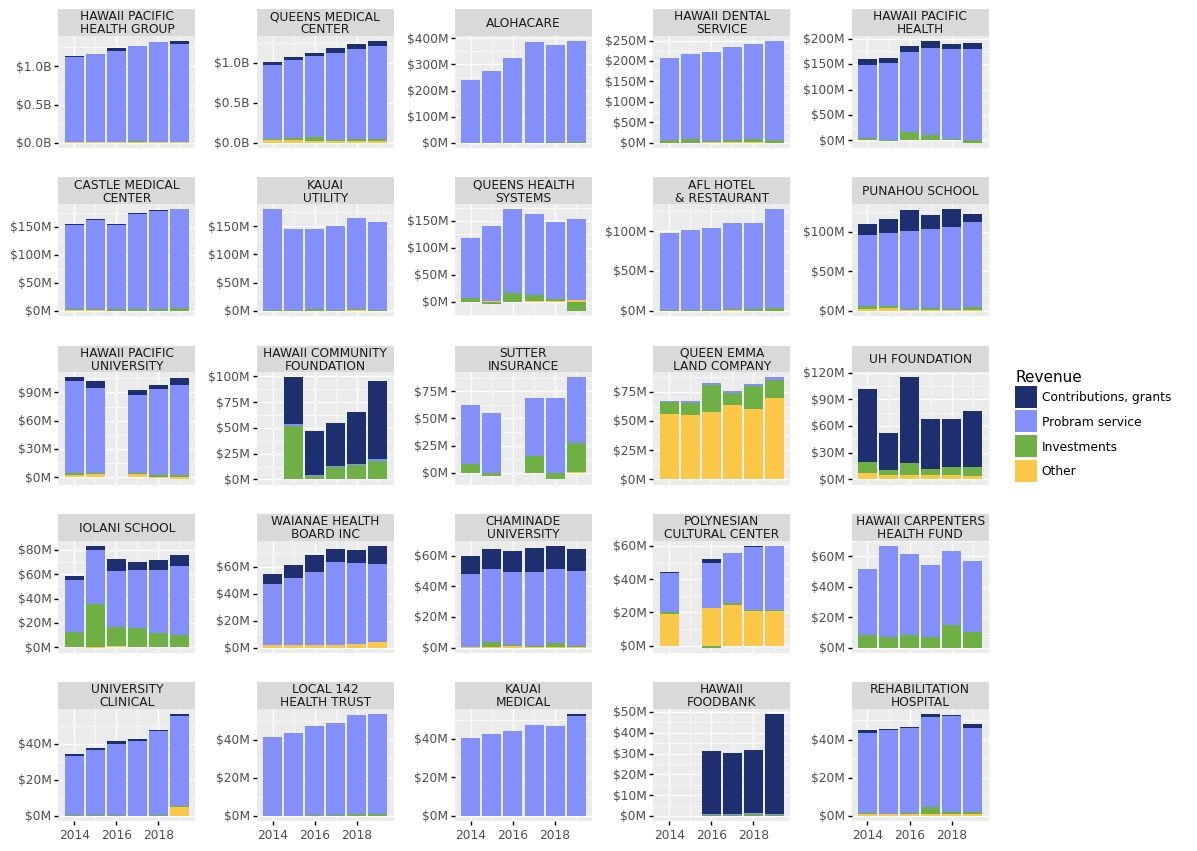

<ggplot: (8766145790031)>

In [11]:
# Plot.

width = 12
ncol = 5
nrow = np.ceil(len(df7['Name'].unique())/ncol)

colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748' ,'#FF8C00']

def y_label(xs):
    if max(xs) > 5e8: return [f'${x/1e9:.1f}B' for x in xs]
    else:             return [f'${x/1e6:.0f}M' for x in xs]

p1 = (p9.ggplot(df7)
    + p9.facet_wrap('Name', ncol=ncol, scales='free_y')
    + p9.theme(figure_size=(width, 0.85*width/ncol*nrow))
    + p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.45})

    + p9.geom_col(p9.aes(x='Year', y='Dollars', fill='Revenue'))
    + p9.xlab('')
    + p9.ylab('')
    + p9.scale_fill_manual(values=colors)
    + p9.scale_y_continuous(labels= y_label))

display(p1)